In [1]:
import sys

import numpy as np

sys.path.insert(0, ".../src/")
sys.path.insert(1, ".../dataset/")

In [5]:
import pennylane as qml
from qcnn import QCNNArchitecture
from utils import *
from plot_results import Plot_results, Plot_Confusion_Matrix
from jax import numpy as jnp
import matplotlib.pyplot as plt
#from dataset.digits import X_train, y_train, X_test, y_test, X_val, y_val

In [6]:
params_size = 43
lr = 0.01
seed = 2222
wires = list(range(6))
dev = qml.device("default.qubit", wires=6)
n_epochs = 200
batch_size = 32

In [8]:
from sklearn.utils import gen_batches
import numpy as np


def training(seed: int, model: callable, selected_shape: int, n_epochs: int, batch_size: int,
             X_train: jnp.array, y_train: jnp.array, X_val: jnp.array, y_val: jnp.array) -> list:
    """
    Functions which trains the QCNN model on digits dataset with parameters chosen by the user.
    :param seed: (int) Seed for reproducibility;
    :param model: (callable) The QCNN model to train;
    :param selected_shape: (int) Number of parameters to pass within the model;
    :param n_epochs: (int) Number of epochs to train the model with;
    :param batch_size: (int) Batch size.
    :return: (list) List of values:
    - train_cost_epochs (list) List of training cost values;
    - train_acc_epochs (list) List of training accuracy values;
    - val_cost_epochs (list) List of validation cost values;
    - val_acc_epochs (list) List of validation accuracy values;
    - optimal_params (list) List of optimal parameters for the QCNN assumed to be the last ones.
    """
    updated_params = np.zeros(shape=[200, 43])
    updated_val_acc = np.zeros(shape=[200, 1])
    key = jax.random.PRNGKey(seed)
    initial_params = jax.random.normal(key, shape=(selected_shape,))
    key = jax.random.split(key)[0]
    params = jnp.copy(initial_params)
    optimizer = optax.adam(learning_rate=lr)
    opt_state = optimizer.init(initial_params)
    train_cost_epochs, train_acc_epochs, val_cost_epochs, val_acc_epochs = [], [], [], []

    for epoch in range(1, n_epochs + 1):
        idxs_dataset = jax.random.choice(key, jnp.array(list(range(X_train.shape[0]))), shape=(X_train.shape[0],),
                                         replace=False)
        key = jax.random.split(key)[0]
        for i in gen_batches(X_train.shape[0],
                             batch_size):
            idxs = idxs_dataset[i]
            params, opt_state, cost = optimizer_update(opt_state, params, X_train[idxs, :], y_train[idxs], model)

        cost = optax_bce(X_train, y_train, params, model)
        val_cost = optax_bce(X_val, y_val, params, model)
        train_acc = accuracy(X_train, y_train, params, model)
        val_acc = accuracy(X_val, y_val, params, model)
        train_cost_epochs.append(cost)
        val_cost_epochs.append(val_cost)
        train_acc_epochs.append(train_acc)
        val_acc_epochs.append(val_acc)
        updated_params[epoch-1, :] = params
        updated_val_acc[epoch-1, :] = val_acc
        print(f"Epoch: {epoch}, ---Train loss: ", cost, "---Train acc: ", train_acc,
              "| ---Val loss: ", val_cost, "---Val acc: ", val_acc)
    last_params = params
    optimal_params_index = tracking_params(updated_val_acc)
    optimal_params = updated_params[optimal_params_index]
    optimal_params = np.reshape(optimal_params, newshape=(optimal_params.shape[1], optimal_params.shape[0]))
    return [train_cost_epochs, train_acc_epochs, val_cost_epochs, val_acc_epochs, last_params, optimal_params]


In [9]:
@qml.qnode(device=dev, interface="jax")
def qcnn(data: jnp.array, params: jnp.array) -> qml.probs:
    """
    It computes the QCNN architecture and returns probabilities of detecting a class of images.
    :param data: (jnp.array) The input data to encode;
    :param params: (jnp.array) The weights within the layers;
    :return: probs: (list) The probabilities of detecting a class.
    """
    circuit = QCNNArchitecture(device=dev, wires=wires)
    qml.AmplitudeEmbedding(features=data, wires=range(len(wires)), normalize=True, pad_with=0.)
    circuit.QCNN(params)
    probs = qml.probs(wires=[3, 5])
    return probs

Now we load and pre-process the dataset:

In [10]:
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

In [28]:
import ROOT

Welcome to JupyROOT 6.30/06


In [29]:
file_path = "./practice_train_5k.root"
root_file = ROOT.TFile(file_path, "READ")

Warning in <TClass::Init>: no dictionary for class larcv::EventImage2D is available
Warning in <TClass::Init>: no dictionary for class larcv::EventBase is available
Warning in <TClass::Init>: no dictionary for class larcv::Image2D is available
Warning in <TClass::Init>: no dictionary for class larcv::ImageMeta is available
Warning in <TClass::Init>: no dictionary for class larcv::BBox2D is available
Warning in <TClass::Init>: no dictionary for class larcv::Point2D is available
Warning in <TClass::Init>: no dictionary for class larcv::EventParticle is available
Warning in <TClass::Init>: no dictionary for class larcv::ParticleSet is available
Warning in <TClass::Init>: no dictionary for class larcv::Particle is available
Warning in <TClass::Init>: no dictionary for class larcv::Vertex is available
Warning in <TClass::Init>: no dictionary for class larcv::BBox3D is available
Warning in <TClass::Init>: no dictionary for class larcv::Point3D is available


In [30]:
root_file.ls()

TFile**		./practice_train_5k.root	
 TFile*		./practice_train_5k.root	
  KEY: TTree	image2d_data_tree;1	data tree
  KEY: TTree	particle_mctruth_tree;1	mctruth tree


In [32]:
tree_name = "image2d_data_tree"
if root_file.GetListOfKeys().Contains(tree_name):
    tree = root_file.Get(tree_name)

In [34]:
branches = tree.GetListOfBranches()
for branch in branches:
    print(branch.GetName())

image2d_data_branch


In [11]:
def normalize_data(data: np.array) -> np.array:
    """
    Normalize the dataset.
    :param data: (np.array) the data to be normalized;
    :return scaled_data: (np.array) the normalized data.
    """
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(data)
    return scaled_data

In [12]:
def select_binary_classes(data: np.array, target: np.array, classes: tuple[int]) -> tuple:
    """
    Selects samples from the dataset that belong to the specified binary classes.
    :param data: (np.array) the data array;
    :param target: (np.array) the labels array;
    :param classes: (np.array) the selected classes.
    Returns:
    :return selected_data: (np.array) the selected samples extracted from the dataset;
    :return selected_target: (np.array) the corresponding target labels.
    """
    mask = np.isin(target, classes)
    selected_data = data[mask]
    selected_target = target[mask]
    return selected_data, selected_target

In [13]:
digits = load_digits()
X, y = digits.data, digits.target
klass = (0, 1, 2, 3)
X_binary, y_binary = select_binary_classes(X, y, classes=klass)
X_binary_normalized = normalize_data(X_binary)
X_train, X_val, y_train, y_val = train_test_split(X_binary_normalized, y_binary, random_state=seed, test_size=0.5)
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, random_state=seed, test_size=0.2)

X_train = jnp.asarray(X_train)
y_train = jnp.asarray(y_train)
X_test = jnp.asarray(X_test)
y_test = jnp.asarray(y_test)
X_val = jnp.asarray(X_val)
y_val = jnp.asarray(y_val)

In [24]:
X.shape

(1797, 64)

In [27]:
y

array([0, 1, 2, ..., 8, 9, 8])

In [14]:
random_key = jax.random.PRNGKey(seed)
uniform_params = jax.random.uniform(key=random_key, shape=(params_size,))
features = jax.random.uniform(key=random_key, shape=(X_train.shape[0]*X_train.shape[1],1), minval=-1.0, maxval=1.0)

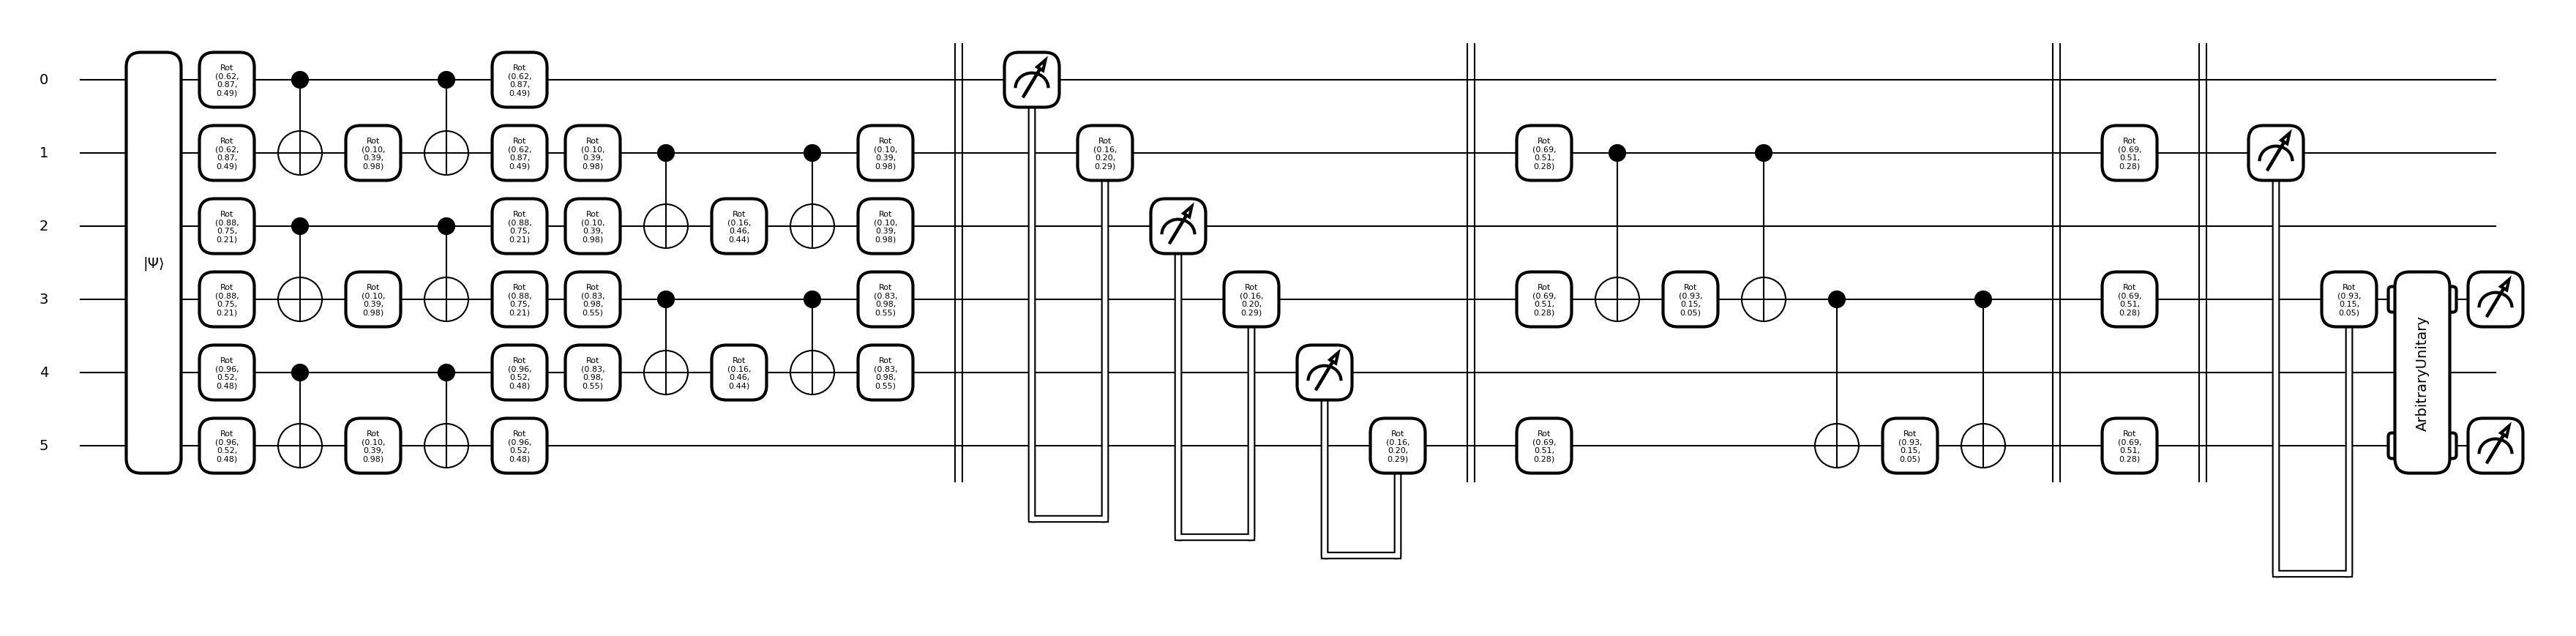

In [15]:
qml.draw_mpl(qnode=qcnn, decimals=2)(features, uniform_params)
plt.show()

In [16]:
q_model = SelectModel(qcnn)


In [17]:
loss_train, acc_train, loss_val, acc_val, last_params, opt_params = (
    training(seed=seed, model=q_model, selected_shape=params_size, n_epochs=n_epochs,
         batch_size=batch_size, X_train=X_train, y_train=y_train,
         X_val=X_val, y_val=y_val)
)

Epoch: 1, ---Train loss:  1.3823189 ---Train acc:  0.28611112 | ---Val loss:  1.3806758 ---Val acc:  0.30555555
Epoch: 2, ---Train loss:  1.3629571 ---Train acc:  0.42222223 | ---Val loss:  1.3691199 ---Val acc:  0.4201389
Epoch: 3, ---Train loss:  1.3458041 ---Train acc:  0.5222222 | ---Val loss:  1.3540121 ---Val acc:  0.5208333
Epoch: 4, ---Train loss:  1.3285551 ---Train acc:  0.62777776 | ---Val loss:  1.3412704 ---Val acc:  0.6006944
Epoch: 5, ---Train loss:  1.314161 ---Train acc:  0.6166667 | ---Val loss:  1.3290185 ---Val acc:  0.5833333
Epoch: 6, ---Train loss:  1.3046439 ---Train acc:  0.6 | ---Val loss:  1.3191955 ---Val acc:  0.5659722
Epoch: 7, ---Train loss:  1.299936 ---Train acc:  0.625 | ---Val loss:  1.3120413 ---Val acc:  0.5868056
Epoch: 8, ---Train loss:  1.296387 ---Train acc:  0.59444445 | ---Val loss:  1.3113904 ---Val acc:  0.5659722
Epoch: 9, ---Train loss:  1.2927958 ---Train acc:  0.6111111 | ---Val loss:  1.3041749 ---Val acc:  0.5763889
Epoch: 10, ---Trai

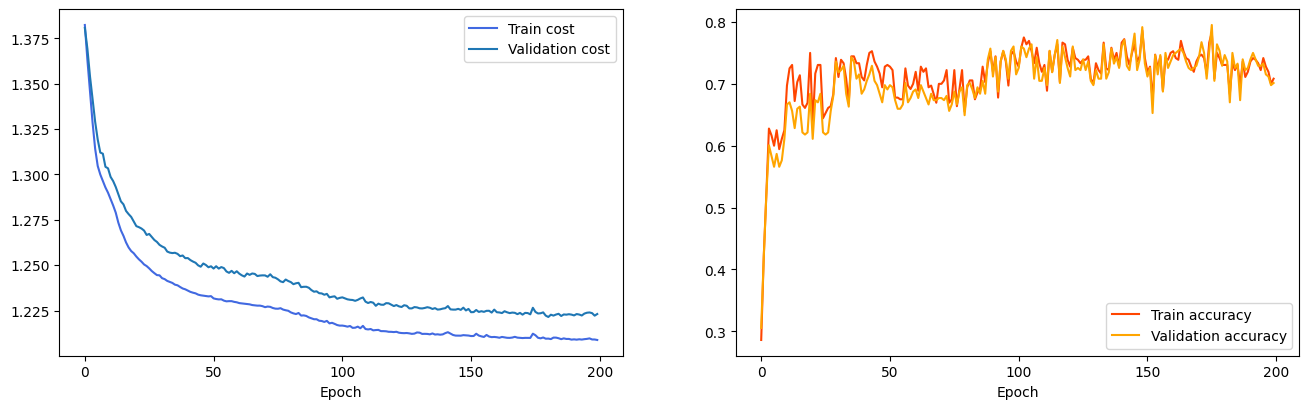

In [18]:
Plot_results(train_cost=loss_train, val_cost=loss_val, train_acc=acc_train, val_acc=acc_val)
plt.show()

In [19]:
test_estimation, test_acc = TestAcc(X=X_test,
                                    y=y_test,
                                    optimal_params=last_params,
                                    quantum_model=q_model)

print("Test acc. QCNN model:", test_acc)

Test acc. QCNN model: 0.7083333333333334


In [20]:
test_estimation_2, test_acc = TestAcc(X=X_test,
                      y=y_test,
                      optimal_params=jnp.array(np.squeeze(opt_params,axis=1)),
                      quantum_model=q_model)

print("Test acc. QCNN model:", test_acc)

Test acc. QCNN model: 0.7083333333333334


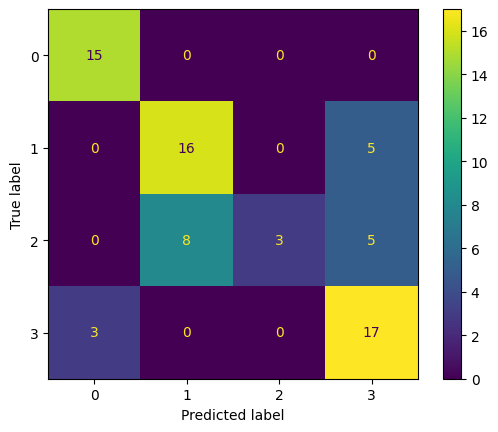

In [21]:
Plot_Confusion_Matrix(y_true=y_test, test_estimation=test_estimation)
plt.show()

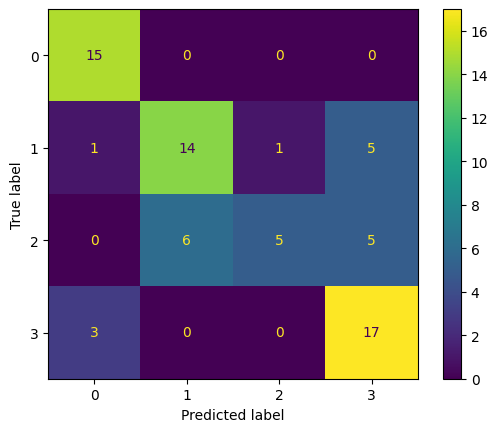

In [22]:
Plot_Confusion_Matrix(y_true=y_test, test_estimation=test_estimation_2)
plt.show()